In [1]:
import math
from simtk import unit
from openmmtools import testsystems, states, mcmc, multistate
import os
import tempfile
import pickle
from perses.annihilation.lambda_protocol import RelativeAlchemicalState
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt

In [2]:
def get_dihedrals(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    index = 0 # of replica
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
    all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
        pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
        all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
        all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
        all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

    dihedrals_all = []
    # write for loop for this part -- old and new atoms
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
        dihedrals = md.compute_dihedrals(traj, np.array([indices]))
#         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices]))) 
        dihedrals_all.append(dihedrals)
    return dihedrals_all[0], dihedrals_all[1], n_iter
        
def plot_dihedrals(dihedrals):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.show()
    
def plot_time_series(dihedrals, n_iter):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)
    
    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("sin(dihedral)")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.show()
    
    return uncorrelated_indices
    
def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.show()

# THR->ALA

In [4]:
htf = pickle.load(open("/data/chodera/zhangi/perses_benchmark/neq/7/36/36_vacuum.pickle", "rb" ))

In [5]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [6]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (C) of chain 0 residue 1 (ALA)>
<Atom 12 (O) of chain 0 residue 1 (ALA)>
<Atom 13 (HB1) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB3) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


### Lambda = 0, new (ALA)

In [9]:
i = 36
aa = 'thr' # lambda = 0
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [10]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf, [13, 10, 8, 6], [18, 10, 8, 6])

100%|██████████| 5001/5001 [00:20<00:00, 247.85it/s]


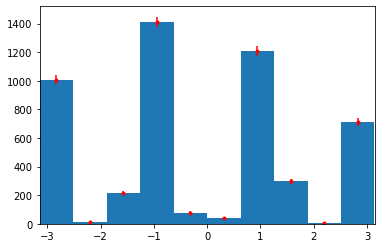

In [11]:
plot_dihedrals(dihedrals_new)

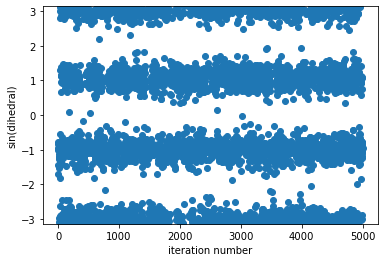

In [12]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


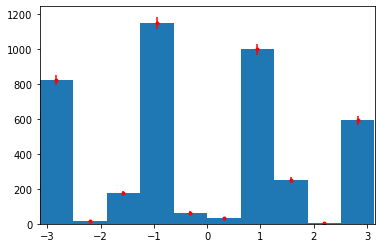

In [13]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (THR)

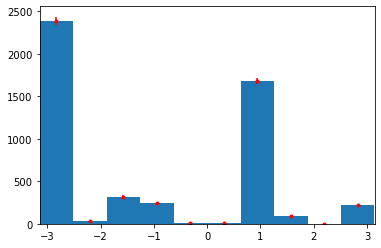

In [14]:
plot_dihedrals(dihedrals_old)

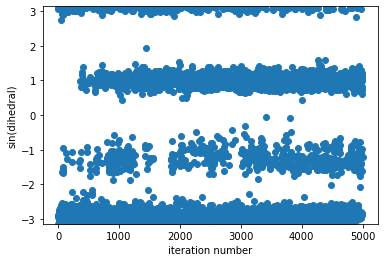

In [15]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

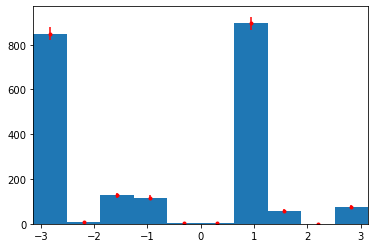

In [16]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (ALA)

In [17]:
i = 36
aa = 'ala' # lambda = 1
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [18]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf, [13, 10, 8, 6], [18, 10, 8, 6])

100%|██████████| 5001/5001 [00:19<00:00, 251.17it/s]


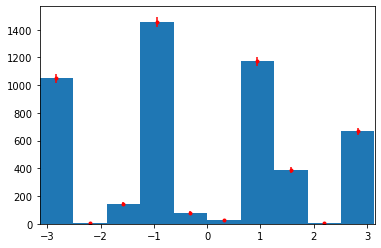

In [19]:
plot_dihedrals(dihedrals_new)

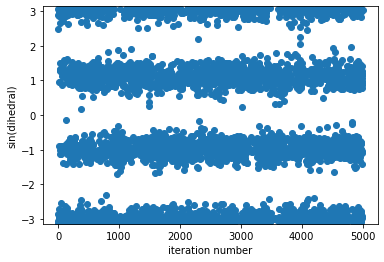

In [20]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


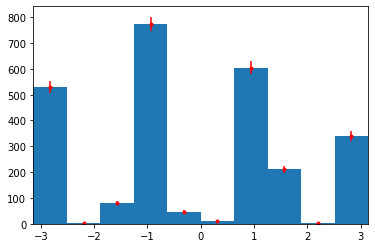

In [21]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (THR)

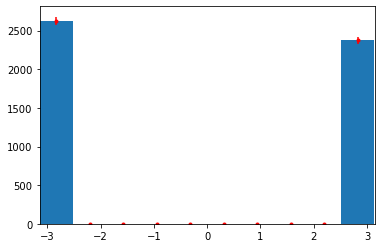

In [22]:
plot_dihedrals(dihedrals_old)

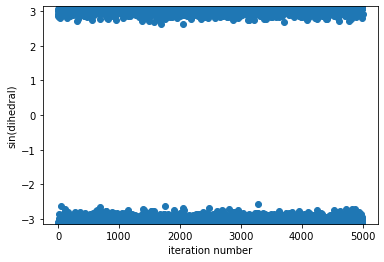

In [23]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

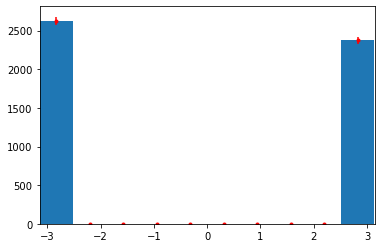

In [24]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

# ALA->THR

In [27]:
htf = pickle.load(open("/data/chodera/zhangi/perses_benchmark/neq/7/35/35_vacuum.pickle", "rb" ))

In [28]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB1) of chain 0 residue 1 (ALA)>
<Atom 12 (HB2) of chain 0 residue 1 (ALA)>
<Atom 13 (HB3) of chain 0 residue 1 (ALA)>
<Atom 14 (C) of chain 0 residue 1 (ALA)>
<Atom 15 (O) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [29]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

### Lambda = 0, new (THR)

In [25]:
i = 35
aa = 'ala' # lambda = 0
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [30]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf, [18, 10, 8, 6], [11, 10, 8, 6])

100%|██████████| 5001/5001 [00:20<00:00, 247.33it/s]


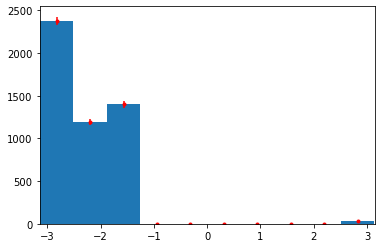

In [31]:
plot_dihedrals(dihedrals_new)

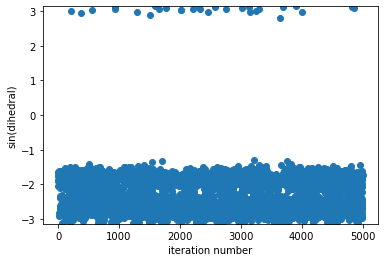

In [32]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


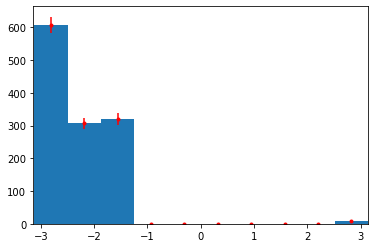

In [33]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (ALA)

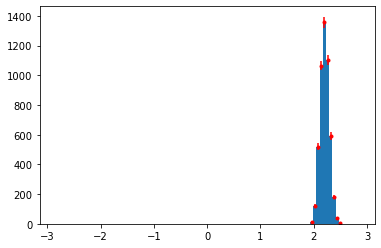

In [34]:
plot_dihedrals(dihedrals_old)

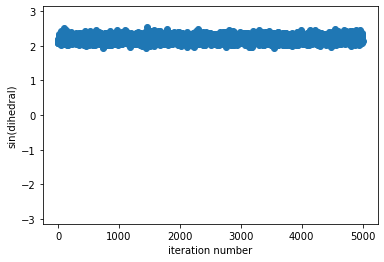

In [35]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

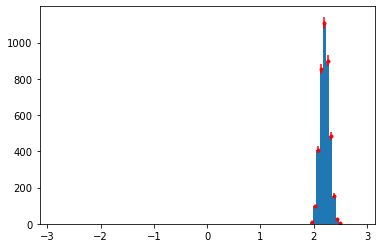

In [36]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (THR)

In [44]:
i = 35
aa = 'thr' # lambda = 1
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [45]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf, [18, 10, 8, 6], [11, 10, 8, 6])

100%|██████████| 5001/5001 [00:19<00:00, 250.14it/s]


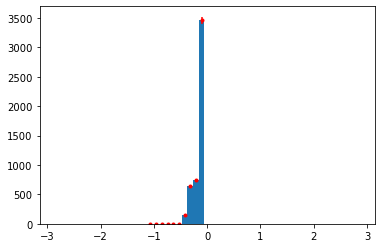

In [46]:
plot_dihedrals(dihedrals_new)

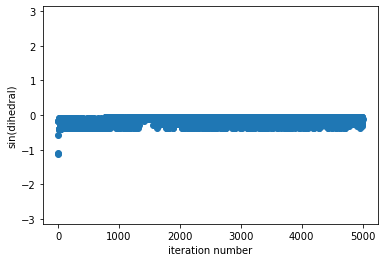

In [47]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


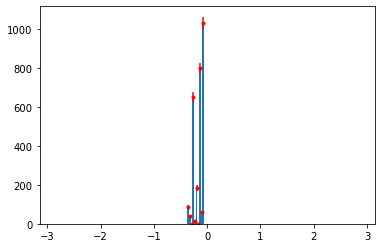

In [48]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (ALA)

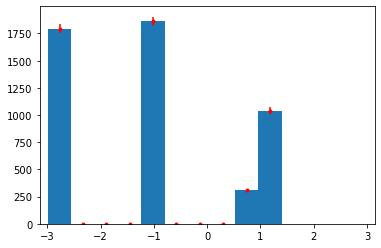

In [49]:
plot_dihedrals(dihedrals_old)

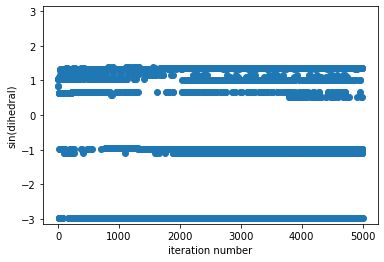

In [50]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

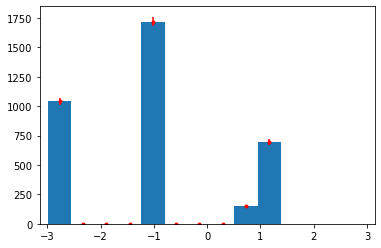

In [51]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)